In [117]:
import tensorflow as tf
import keras
from keras import layers
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
import sys; sys.path.append('../')
from src.pipelines import EmbedCalibrate
from src.postprocessing import TemperatureScaling
from src.supcon import ContrastiveLoss
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Moons decisions boundaries

In [218]:
def sample(seed=None, dim=2):
    np.random.seed(seed)
    # More noise in the moons makes the task harder
    X, y = datasets.make_moons(n_samples=2000, shuffle=True, noise=.3)

    # Rescale and shift the dataset to better fit into zero-one box
    X = (X + 1.6) / 4
    X[:, 0] = X[:, 0] - 0.035
    X[:, 1] = (X[:, 1] - 0.17) * 1.75
    # y = tf.one_hot(y, depth=2)
    
    return X, y

X_train, y_train = sample(1)
X_test, y_test = sample(2)

In [219]:
def plot(clf, plot_min, plot_max, max_prob, title):
    n_grid = 200
    x_plot = np.linspace(plot_min, plot_max, n_grid)
    y_plot = np.linspace(plot_min, plot_max, n_grid)
    
    points = []
    for xx in x_plot:
        for yy in y_plot:
            points.append((yy, xx))
    points = np.array(points)
    
    probs = clf.predict_proba(points)
    
    if max_prob:
        z_plot = probs.max(1)
    else:
        z_plot = probs[:, 0]
    z_plot = z_plot.reshape(len(x_plot), len(y_plot)) * 100
    
    ax = plt.gca()
    
    vmax = 100
    vmin = 50 if max_prob else 0
    plt.contourf(x_plot, y_plot, z_plot, levels=np.linspace(50, 100, 50))
    cbar = plt.colorbar(ticks=np.linspace(vmin, vmax, 6))
    
    cbar.ax.set_title('confidence', fontsize=12, pad=12)
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%', '100%'])
    
    y_np = np.array(y_train)
    X0 = X_train[y_np==0]
    X1 = X_train[y_np==1]
    plt.scatter(X0[:, 0], X0[:, 1], s=20, edgecolors='red', facecolor='None',
                marker='o', linewidths=0.2)
    plt.scatter(X1[:, 0], X1[:, 1], s=20, edgecolors='green', facecolor='None',
                marker='s', linewidths=0.2)
    plt.xlim([plot_min, plot_max])
    plt.ylim([plot_min, plot_max])
    
    margin = 0.01
    rect = matplotlib.patches.Rectangle((-margin, -margin), 1.0+2*margin, 1.0+2*margin, 
                                        linewidth=1.5, color='white', fill=False)
    ax.add_patch(rect)
    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')
#     plt.savefig('figures/moons_{:.1f}_{:.1f}_max_prob={}.pdf'.format(
#         plot_min, plot_max, max_prob), transparent=True)
    plt.show()

KNN o ContrastNN (Honest)


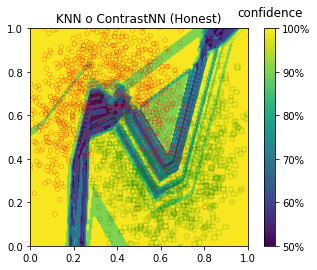

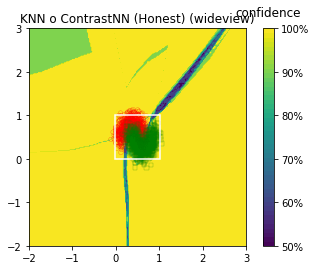

Softmax


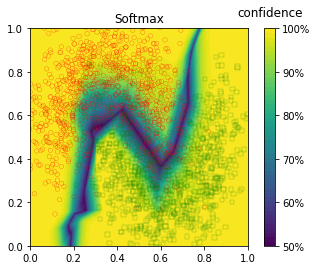

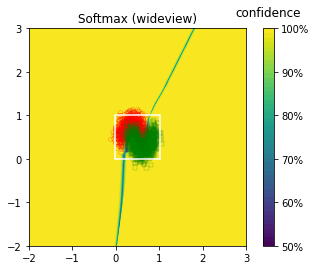

Softmax (Temp scaling)


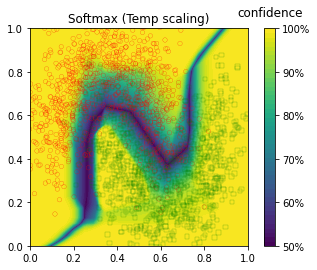

../src/postprocessing.py:20: RuntimeWarning: overflow encountered in exp
  e_x = np.exp(x - np.max(x))
../src/postprocessing.py:21: RuntimeWarning: invalid value encountered in true_divide
  return e_x / e_x.sum(axis=1, keepdims=1)


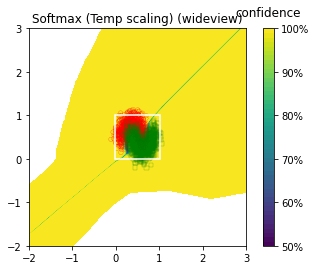

KNN o NN


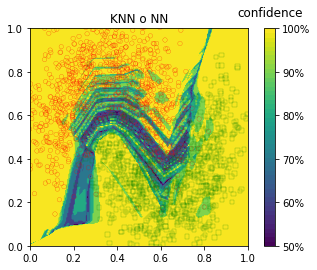

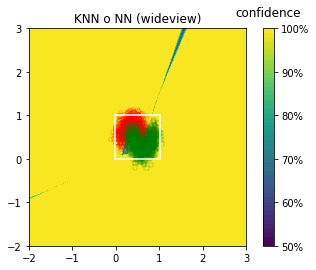

KNN o NN (Honest)


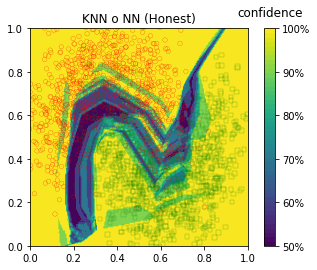

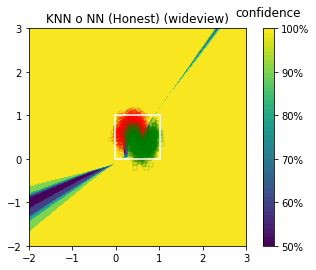

In [220]:
batch_size = 10

# Initialize network for softmax loss
network_softmax = keras.Sequential()
network_softmax.add(keras.layers.InputLayer((2,), batch_size=batch_size))
network_softmax.add(layers.Dense(100, activation='relu'))
network_softmax.add(layers.Dense(100, activation='relu'))
network_softmax.add(layers.Dense(units=2))
network_softmax.add(layers.Activation('softmax'))

softmax_kwargs = {
    "loss": "categorical_crossentropy",
    "optimizer": keras.optimizers.Adam(1e-2),
    "metrics": "acc",
}

# Initialize network for contrastive loss
network_contrastive = keras.Sequential()
network_contrastive.add(keras.layers.InputLayer((2,), batch_size=batch_size))
network_contrastive.add(layers.Dense(100, activation='relu'))
network_contrastive.add(layers.Dense(100, activation='relu'))
network_contrastive.add(layers.Dense(2))

contrastive_kwargs = {
    "loss": ContrastiveLoss(),
    "optimizer": keras.optimizers.Adam(1e-2),
}

knn = KNeighborsClassifier(n_neighbors=10)
temp_scalar = TemperatureScaling()

fit_kwargs = {
    "epochs": 200,
    "batch_size": batch_size,
    "verbose": False
}

clfs = [
    (EmbedCalibrate(network_contrastive, contrastive_kwargs, fit_kwargs, -2, knn, validation_frac=0.3), 'KNN o ContrastNN (Honest)'),
    (EmbedCalibrate(network_softmax, softmax_kwargs, fit_kwargs), 'Softmax'),
    (EmbedCalibrate(network_softmax, softmax_kwargs, fit_kwargs, -2, temp_scalar, validation_frac=0.1), 'Softmax (Temp scaling)'),
    (EmbedCalibrate(network_softmax, softmax_kwargs, fit_kwargs, -3, knn, validation_frac=None), 'KNN o NN'),
    (EmbedCalibrate(network_softmax, softmax_kwargs, fit_kwargs, -3, knn, validation_frac=0.3), 'KNN o NN (Honest)'),
]

for clf, name in clfs:
    print(name)
    clf = clf.fit(X_train, y_train)
    plot(clf, 0.0, 1.0, max_prob=True, title=f'{name}')
    plot(clf, -2.0, 3.0, max_prob=True, title=f'{name} (wideview)')

### Moons calibration curves

Softmax:
	Brier: 0.070
	F1: 0.905

Softmax (Temp scaling):
	Brier: 0.072
	F1: 0.902

KNN o NN:
	Brier: 0.074
	F1: 0.904

KNN o NN (Honest):
	Brier: 0.073
	F1: 0.904



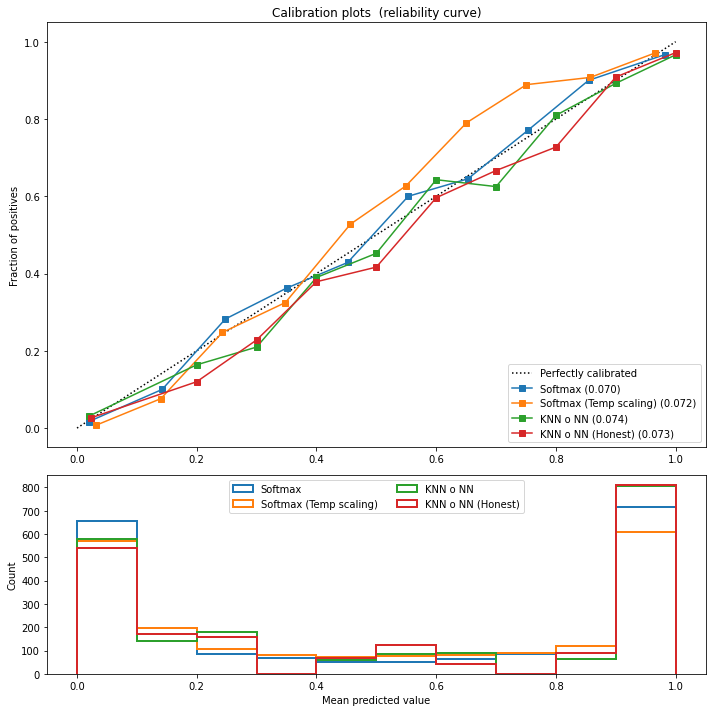

In [134]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, f1_score

fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# Initialize network
network = keras.Sequential()
network.add(keras.Input(shape=(2,)))
network.add(layers.Dense(100, activation='relu'))
network.add(layers.Dense(100, activation='relu'))
network.add(layers.Dense(units=2))
network.add(layers.Activation('softmax'))

knn = KNeighborsClassifier(n_neighbors=10)
temp_scalar = TemperatureScaling()

compile_kwargs = {
    "loss": "categorical_crossentropy",
    "optimizer": keras.optimizers.Adam(1e-2),
    "metrics": "acc",
}
fit_kwargs = {
    "epochs": 200,
    "batch_size": 32,
    "verbose": False
}

clfs = [
    (EmbedCalibrate(network, compile_kwargs, fit_kwargs), 'Softmax'),
    (EmbedCalibrate(network, compile_kwargs, fit_kwargs, -2, temp_scalar, validation_frac=0.1), 'Softmax (Temp scaling)'),
    (EmbedCalibrate(network, compile_kwargs, fit_kwargs, -3, knn, validation_frac=None), 'KNN o NN'),
    (EmbedCalibrate(network, compile_kwargs, fit_kwargs, -3, knn, validation_frac=0.3), 'KNN o NN (Honest)'),
]
for clf, name in clfs:
    clf = clf.fit(X_train, y_train)
    probs = clf.predict_proba(X_test)

    prob_pos = probs[:, 1]
    y_pred = np.argmax(probs, axis=1)

    clf_score = brier_score_loss(y_test, prob_pos, pos_label=y_test.max())
    print("%s:" % name)
    print("\tBrier: %1.3f" % (clf_score))
    print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s (%1.3f)" % (name, clf_score))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

## Gaussian blob posteriors

In [273]:
from sklearn.model_selection import train_test_split

n_samples = 50000
n_bins = 3  # use 3 bins for calibration_curve as we have 3 clusters here

# Generate 3 blobs with 2 classes where the second blob contains
# half positive samples and half negative samples. Probability in this
# blob is therefore 0.5.
centers = [(-5, -5), (0, 0), (5, 5)]
X, y = datasets.make_blobs(n_samples=n_samples, centers=centers, shuffle=False,
                  random_state=42)

y[:n_samples // 2] = 0
y[n_samples // 2:] = 1
sample_weight = np.random.RandomState(42).rand(y.shape[0])

# split train, test for calibration
X_train, X_test, y_train, y_test, sw_train, sw_test = \
    train_test_split(X, y, sample_weight, test_size=0.9, random_state=42)

batch_size = 50

# Initialize network for softmax loss
network_softmax = keras.Sequential()
network_softmax.add(keras.layers.InputLayer((2,), batch_size=batch_size))
network_softmax.add(layers.Dense(100, activation='relu'))
network_softmax.add(layers.Dense(100, activation='relu'))
network_softmax.add(layers.Dense(units=2))
network_softmax.add(layers.Activation('softmax'))

softmax_kwargs = {
    "loss": "categorical_crossentropy",
    "optimizer": keras.optimizers.Adam(1e-2),
    "metrics": "acc",
}

# Initialize network for contrastive loss
network_contrastive = keras.Sequential()
network_contrastive.add(keras.layers.InputLayer((2,), batch_size=batch_size))
network_contrastive.add(layers.Dense(100, activation='relu'))
network_contrastive.add(layers.Dense(100, activation='relu'))
network_contrastive.add(layers.Lambda(lambda x: tf.linalg.normalize(x, axis=1)[0]))
network_contrastive.add(layers.Dense(2))#, activation='relu'))
network_contrastive.add(layers.Lambda(lambda x: tf.linalg.normalize(x, axis=1)[0]))

contrastive_kwargs = {
    "loss": ContrastiveLoss(),
    "optimizer": keras.optimizers.Adam(1e-2),
}

knn = KNeighborsClassifier(n_neighbors=20)
temp_scalar = TemperatureScaling()

fit_kwargs = {
    "epochs": 100,
    "batch_size": batch_size,
    "verbose": False
}

clfs = [
    (EmbedCalibrate(network_contrastive, contrastive_kwargs, fit_kwargs, -3, knn, validation_frac=0.3), 'KNN o ContrastNN (Honest)'),
    (EmbedCalibrate(network_softmax, softmax_kwargs, fit_kwargs), 'Softmax'),
    (EmbedCalibrate(network_softmax, softmax_kwargs, fit_kwargs, -2, temp_scalar, validation_frac=0.1), 'Softmax (Temp scaling)'),
    (EmbedCalibrate(network_softmax, softmax_kwargs, fit_kwargs, -3, knn, validation_frac=None), 'KNN o NN'),
    (EmbedCalibrate(network_softmax, softmax_kwargs, fit_kwargs, -3, knn, validation_frac=0.3), 'KNN o NN (Honest)'),
]

pos_probs = {}
for clf, name in clfs:
    print(name)
    clf = clf.fit(X_train, y_train)
    probs = clf.predict_proba(X_test)

    pos_probs[name] = probs[:, 1]

KNN o ContrastNN (Honest)
Softmax
Softmax (Temp scaling)


../src/postprocessing.py:20: RuntimeWarning: overflow encountered in exp
  e_x = np.exp(x)
../src/postprocessing.py:21: RuntimeWarning: invalid value encountered in true_divide
  return e_x / e_x.sum(axis=1, keepdims=1)


KNN o NN
KNN o NN (Honest)


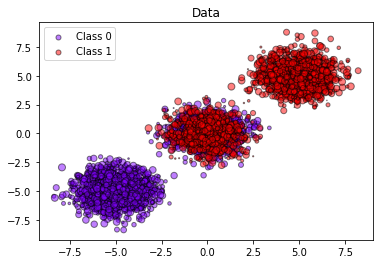

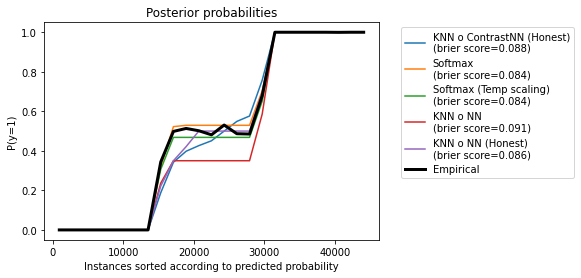

In [275]:
# #############################################################################
# Plot the data and the predicted probabilities
from matplotlib import cm

plt.figure()
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X_train[y_train == this_y]
    this_sw = sw_train[y_train == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1], s=this_sw * 50,
                c=color[np.newaxis, :],
                alpha=0.5, edgecolor='k',
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.title("Data")

plt.figure()

for name, probs in pos_probs.items():
    order = np.lexsort((probs, ))
    score = brier_score_loss(y_test, probs, sample_weight=sw_test)
    plt.plot(np.linspace(0, y_test.size, 51)[1::2],
             probs[order].reshape(25, -1).mean(1), label=f'{name}\n(brier score={score:.3f})')
plt.plot(np.linspace(0, y_test.size, 51)[1::2],
         y_test[order].reshape(25, -1).mean(1),
         'k', linewidth=3, label=r'Empirical')
plt.ylim([-0.05, 1.05])
plt.xlabel("Instances sorted according to predicted probability")
plt.ylabel("P(y=1)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',)
plt.title("Posterior probabilities")

plt.show()

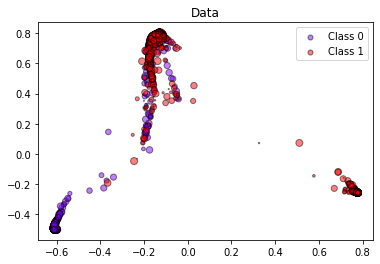

In [264]:
X_plot = clfs[0][0].transformer_(X_train)

from sklearn.decomposition import PCA
X_plot = PCA(n_components=2).fit_transform(X_plot)

plt.figure()
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X_plot[y_train == this_y]
    this_sw = sw_train[y_train == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1], s=this_sw * 50,
                c=color[np.newaxis, :],
                alpha=0.5, edgecolor='k',
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.title("Data")
plt.show()

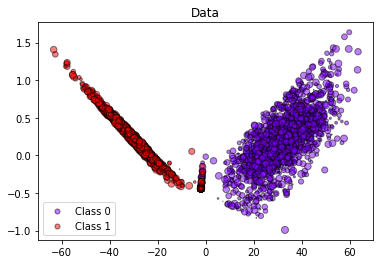

In [265]:
X_plot = clfs[1][0].transformer_(X_train)

from sklearn.decomposition import PCA
X_plot = PCA(n_components=2).fit_transform(X_plot)

plt.figure()
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X_plot[y_train == this_y]
    this_sw = sw_train[y_train == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1], s=this_sw * 50,
                c=color[np.newaxis, :],
                alpha=0.5, edgecolor='k',
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.title("Data")
plt.show()

In [314]:
def get_activations(model, x, layer_indices):
    acts = []
    for i in layer_indices:
        x = model.layers[i](x)
        bool_mat = x.numpy() > 0
        acts.append(bool_mat.astype(int))
    return acts

def plot_decision_boundaries(model, X, y, layer_indices, n_activations=None, xlim=None, ylim=None):
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.scatter(*list(zip(*X)), c=y, cmap='RdBu', alpha=0.25)

    # plot the decision function
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 100)
    yy = np.linspace(ylim[0], ylim[1], 100)
    YY, XX = np.meshgrid(yy, xx)
    XY = np.vstack([XX.ravel(), YY.ravel()]).T

    # plot linear region boundaries
    activations = get_activations(model, XY, layer_indices)
    colors = ['red', 'blue', 'black']
    for i in range(len(activations[:n_activations])):
        acts = np.hstack(activations[:len(activations)-i])
        Z = np.unique(acts, axis=0, return_inverse=True)[1].reshape(XX.shape)
        ax.contour(XX, YY, Z, colors=colors[i], alpha=0.5)

    plt.show()

In [316]:
n_samples = 2000
# More noise in the moons makes the task harder
X, y = datasets.make_moons(n_samples=n_samples, shuffle=True, noise=.1)
# X, y = datasets.make_circles(n_samples=n_samples, random_state=8)
# Rescale and shift the dataset to better fit into zero-one box
X = (X + 1.6) / 4
X[:, 0] = X[:, 0] - 0.035
X[:, 1] = (X[:, 1] - 0.17) * 1.75

batch_size=10

# Initialize network for contrastive loss
network_contrastive = keras.Sequential()
network_contrastive.add(keras.layers.InputLayer((2,)))#, batch_size=batch_size))
network_contrastive.add(layers.Dense(10, activation='relu'))
network_contrastive.add(layers.Dense(10, activation='relu'))
network_contrastive.add(layers.Dense(2))#, activation='relu'))
# network_contrastive.add(layers.Lambda(lambda x: tf.linalg.normalize(x, axis=1)[0]))
network_contrastive.add(layers.Activation('softmax'))

contrastive_kwargs = {
    "loss": "categorical_crossentropy",#ContrastiveLoss(),
    "optimizer": keras.optimizers.Adam(1e-2),
}

knn = KNeighborsClassifier(n_neighbors=20)

fit_kwargs = {
    "epochs": 200,
    "batch_size": batch_size,
    "verbose": False
}

clf = EmbedCalibrate(network_contrastive, contrastive_kwargs, fit_kwargs, -3, knn, validation_frac=0.3)
clf = clf.fit(X, y)

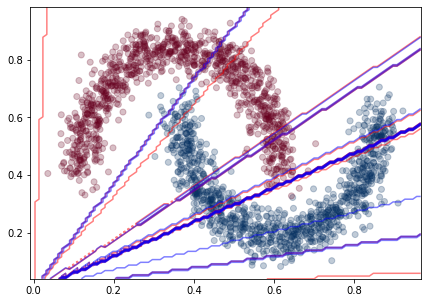

In [317]:
plot_decision_boundaries(clf.network, X, y, [0, 1])

In [319]:
for l in clf.network.layers:
    print(l.activation)

<function relu at 0x7fd36bb4baf0>
<function relu at 0x7fd36bb4baf0>
<function linear at 0x7fd36bb591f0>
<function softmax at 0x7fd36bb4b430>


In [325]:
clf.network.layers[0].get_weights()#get_config()

[array([[-0.39296558, -0.0968715 ,  0.35092348,  0.47527212, -0.2157428 ,
          0.4697283 ,  0.3993464 , -0.13666624,  0.17619592, -0.6403025 ],
        [ 0.6587773 ,  0.4826836 ,  0.3717168 , -0.5500339 , -0.57241136,
         -0.25778008, -0.62007034, -0.21444166, -0.5295408 ,  0.7009397 ]],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)]